# Importando as Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout # Added Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid # Added TimeSeriesSplit, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping # Added EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm # Import tqdm

# Tratando os dados e definindo variáveis

In [2]:
# --- Configuration ---
TARGET = "T (degC)"  # Target variable
SEQ_LENGTH = 24      # Past hours as input sequence length
FORECAST_STEPS = 24  # Predict next 24 hours
TEST_SIZE_YEARS = 1  # Size of the test set in years
EPOCHS = 5         # Maximum epochs for training
BATCH_SIZE = 32
PATIENCE = 10         # Patience for EarlyStopping
LSTM_UNITS = 100      # Number of LSTM units per layer - for hyperparameter tuning later
DROPOUT_RATE = 0.2    # Dropout rate - for hyperparameter tuning later

In [3]:
# --- Data Loading and Preprocessing ---
parent_path = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(parent_path, 'data', 'jena_climate_2009_2016.csv'))

df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index('Date Time', inplace=True)
df = df.sort_index()
df = df.resample('h').mean()

# Data Cleaning - Handling non-positive wind speed and dropna after resampling
df['wv (m/s)'] = df['wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df['max. wv (m/s)'] = df['max. wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df = df.dropna()

# Create Complete DatetimeIndex and Interpolate Missing Values
start_date = df.index.min()
end_date = df.index.max()
hourly_index = pd.date_range(start=start_date, end=end_date, freq='h')
df = df.reindex(hourly_index)
df = df.interpolate(method='time')

# Outlier Handling (Simple IQR method)
Q1 = df['T (degC)'].quantile(0.25)
Q3 = df['T (degC)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['T (degC)'] = np.where(df['T (degC)'] < lower_bound, lower_bound, df['T (degC)'])
df['T (degC)'] = np.where(df['T (degC)'] > upper_bound, upper_bound, df['T (degC)'])

# Feature Engineering - Time-based features
df["hour"] = df.index.hour
df["dayofyear"] = df.index.dayofyear
df["year"] = df.index.year

In [4]:

# Fit scalers on the original dataframe (before train-test split)
target_scaler = MinMaxScaler()
target_scaler.fit(df[[TARGET]])
feature_scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled.drop(columns=['Tpot (K)', 'Tdew (degC)', 'max. wv (m/s)'], inplace=True)
df_scaled[df_scaled.columns] = feature_scaler.fit_transform(df_scaled)


# Treinando e testando o modelo

In [5]:

# --- Sequence Creation ---
def create_multistep_sequences(data, target_col, seq_length, steps_forward):
    X, y, y_dates = [], [], []
    for i in range(len(data) - seq_length - steps_forward):
        X.append(data.iloc[i : i + seq_length].values)
        y_segment = data[target_col].iloc[i + seq_length : i + seq_length + steps_forward].values
        y.append(y_segment)
        y_dates.append(data.index[i + seq_length : i + seq_length + steps_forward])
    return np.array(X), np.array(y), y_dates

X, y, y_dates = create_multistep_sequences(df_scaled, TARGET, SEQ_LENGTH, FORECAST_STEPS)


In [6]:
# --- Time-Based Train-Test Split ---
split_index = len(X) - (TEST_SIZE_YEARS * 365 * 24) # Test set is last TEST_SIZE_YEARS years
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_dates_test = y_dates[split_index:]

In [7]:
# --- Model Definition and Hyperparameter Tuning (GridSearchCV) ---
def build_lstm_model(lstm_units, dropout_rate, seq_length, num_features, forecast_steps, verbose=1): # Added verbose parameter
    model = Sequential()
    model.add(Input(shape=(seq_length, num_features)))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(forecast_steps))
    return model

print("\nHyperparameter Tuning with GridSearchCV and TimeSeriesSplit:")
param_grid = {
    'lstm_units': [50, 100], # Example values, expand for wider search
    'dropout_rate': [0.0, 0.2] # Example values
}
tscv = TimeSeriesSplit(n_splits=3) # TimeSeriesSplit for CV
best_mae = float('inf')
best_params = None
best_model_tuned = None


Hyperparameter Tuning with GridSearchCV and TimeSeriesSplit:


In [8]:

param_combinations = list(ParameterGrid(param_grid)) # Create a list of parameter combinations
for params in tqdm(param_combinations, desc="Tuning Hyperparameters"): # Wrap with tqdm
    print(f"\nTesting parameters: {params}")
    model = build_lstm_model(params['lstm_units'], params['dropout_rate'], SEQ_LENGTH, X.shape[2], FORECAST_STEPS)
    model.compile(optimizer='adam', loss='mae') # Keep optimizer and loss fixed for tuning

    # Early Stopping Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping]) # Added callbacks

    val_mae = min(history.history['val_loss']) # Get minimum validation MAE from training history
    print(f"Validation MAE: {val_mae:.4f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_params = params
        best_model_tuned = model # Save the best model

print("\nBest parameters found:", best_params)
print("Best Validation MAE:", best_mae)

Tuning Hyperparameters:   0%|          | 0/4 [00:00<?, ?it/s]


Testing parameters: {'dropout_rate': 0.0, 'lstm_units': 50}
Epoch 1/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0828 - val_loss: 0.0414
Epoch 2/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0407 - val_loss: 0.0370
Epoch 3/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0383 - val_loss: 0.0366
Epoch 4/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - loss: 0.0370 - val_loss: 0.0348
Epoch 5/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 144s 75ms/step - loss: 0.0362 - val_loss: 0.0357


Tuning Hyperparameters:  25%|██▌       | 1/4 [04:48<14:24, 288.24s/it]

Validation MAE: 0.0348

Testing parameters: {'dropout_rate': 0.0, 'lstm_units': 100}
Epoch 1/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 168s 77ms/step - loss: 0.0709 - val_loss: 0.0372
Epoch 2/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 107s 56ms/step - loss: 0.0399 - val_loss: 0.0365
Epoch 3/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 0.0376 - val_loss: 0.0363
Epoch 4/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0367 - val_loss: 0.0355
Epoch 5/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - loss: 0.0361 - val_loss: 0.0370


Tuning Hyperparameters:  50%|█████     | 2/4 [11:22<11:41, 350.74s/it]

Validation MAE: 0.0355

Testing parameters: {'dropout_rate': 0.2, 'lstm_units': 50}
Epoch 1/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0899 - val_loss: 0.0430
Epoch 2/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0467 - val_loss: 0.0390
Epoch 3/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0438 - val_loss: 0.0384
Epoch 4/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0422 - val_loss: 0.0433
Epoch 5/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0411 - val_loss: 0.0433


Tuning Hyperparameters:  75%|███████▌  | 3/4 [13:17<04:03, 243.02s/it]

Validation MAE: 0.0384

Testing parameters: {'dropout_rate': 0.2, 'lstm_units': 100}
Epoch 1/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 0.0841 - val_loss: 0.0454
Epoch 2/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0446 - val_loss: 0.0400
Epoch 3/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0421 - val_loss: 0.0375
Epoch 4/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0406 - val_loss: 0.0376
Epoch 5/5
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - loss: 0.0394 - val_loss: 0.0377


Tuning Hyperparameters: 100%|██████████| 4/4 [16:04<00:00, 241.13s/it]

Validation MAE: 0.0375

Best parameters found: {'dropout_rate': 0.0, 'lstm_units': 50}
Best Validation MAE: 0.034766633063554764


In [9]:
# --- Final Model Training with Best Hyperparameters ---
final_model = best_model_tuned # Use the best tuned model

# --- Model Summary ---
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,924 (433.30 KB)

 Trainable params: 36,974 (144.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 73,950 (288.87 KB)

In [10]:
# --- Evaluation on Test Set ---
y_pred_scaled_full = final_model.predict(X_test)
y_pred_inv_full = target_scaler.inverse_transform(y_pred_scaled_full.reshape(-1, 1)).flatten()
y_test_inv_full = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_inv_full, y_pred_inv_full)
mse = mean_squared_error(y_test_inv_full, y_pred_inv_full)
r2  = r2_score(y_test_inv_full, y_pred_inv_full)

print("\n--- Evaluation on Test Set (Full) ---")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

--- Evaluation on Test Set (Full) ---
Mean Absolute Error: 1.680850625975095
Mean Squared Error: 4.98137044147225
R² Score: 0.9255140820777564


In [11]:
# --- Forecast for the Last Test Sample and Visualization ---
def forecast_24h(model, X_input):
    y_pred = model.predict(X_input)
    return y_pred.flatten()

X_input = X_test[-1].reshape(1, SEQ_LENGTH, X.shape[2])
y_pred = forecast_24h(final_model, X_input) # Use final_model
y_pred_inversed = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = target_scaler.inverse_transform(y_test[-1].reshape(-1, 1)).flatten() # Actual values for last sample
predicted_dates = y_dates_test[-1] # Dates for last sample


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


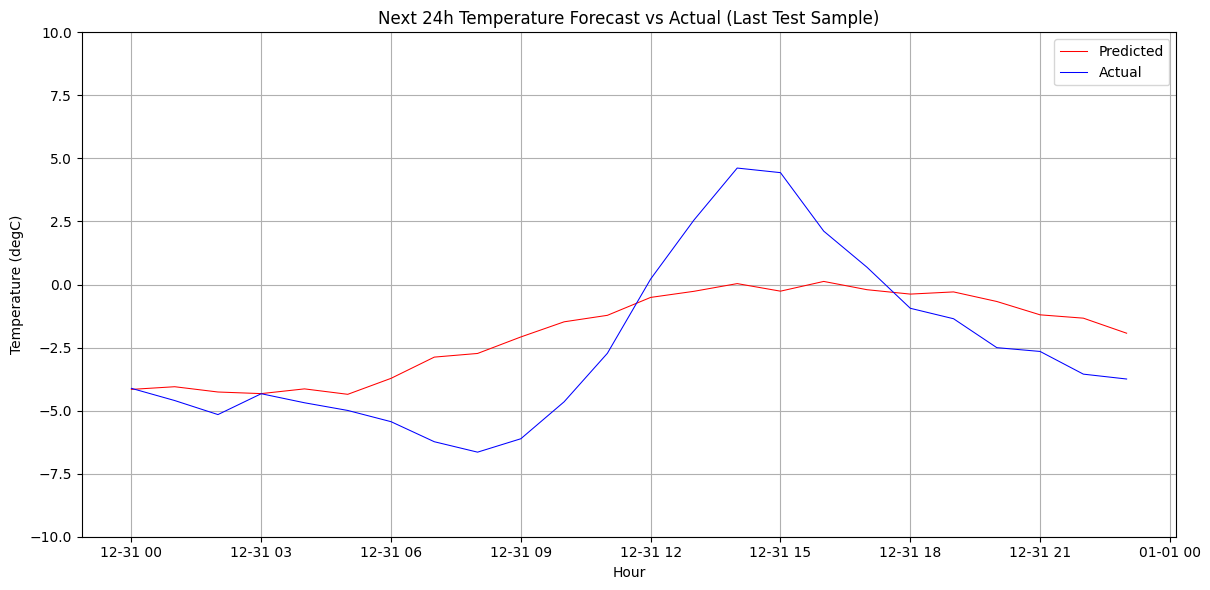

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(predicted_dates, y_pred_inversed, label="Predicted", linewidth=0.75, color='red')
plt.plot(predicted_dates, y_test_actual, label="Actual", linewidth=0.75, color='blue')
plt.xlabel("Hour")
plt.ylabel("Temperature (degC)")
plt.title("Next 24h Temperature Forecast vs Actual (Last Test Sample)") # More descriptive title
plt.legend()
plt.tight_layout()
plt.ylim(-10, 10)
plt.grid(True)
plt.show()

# Testando a previsão em mais de um periodo

In [13]:
predictions = [1, 25, 49]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


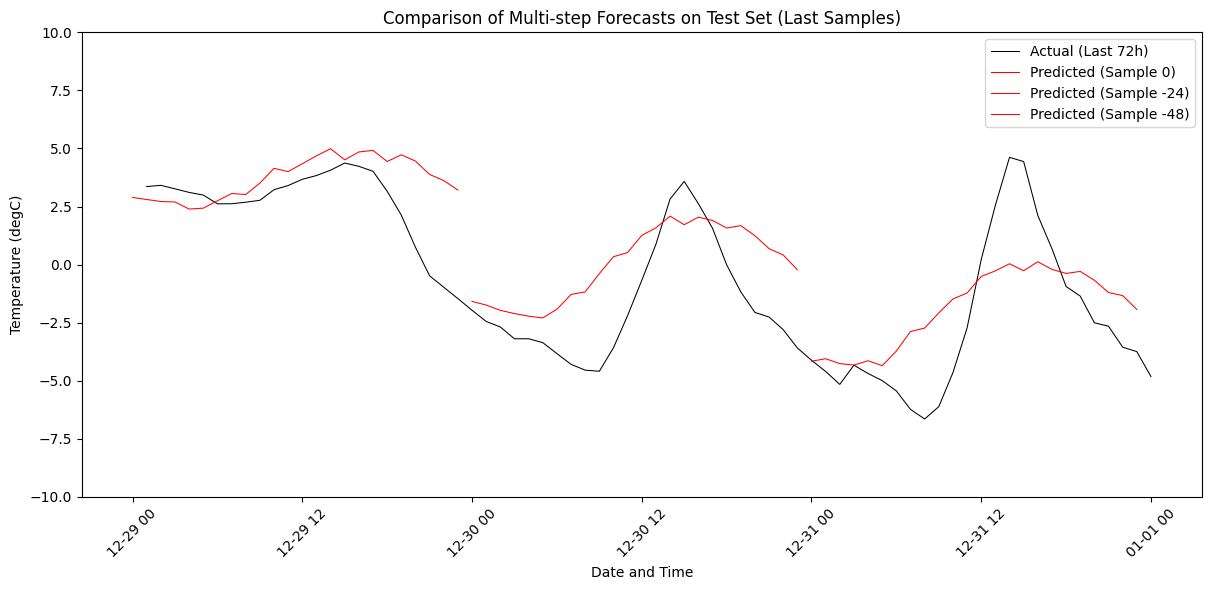

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-72:], df[TARGET][-72:], label="Actual (Last 72h)", linewidth=0.75, color='black') # Plot actual for context

num_predictions_to_plot = 3 # You want to plot 3 predictions, adjust as needed
prediction_indices = range(1, num_predictions_to_plot + 1) # Indices for the last 1, 2, 3 samples

colors = ['red', 'green', 'purple'] # Colors for different predictions - customize as needed

for i in predictions:
    X_input = X_test[-i].reshape(1, SEQ_LENGTH, X.shape[2]) # Get X_input for the sample
    y_pred_scaled = forecast_24h(final_model, X_input) # Make prediction
    y_pred_inversed = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() # Inverse transform

    predicted_dates = y_dates_test[-i] # Get dates for this forecast

    plt.plot(predicted_dates, y_pred_inversed, label=f"Predicted (Sample {-i+1})", linewidth=0.75, color=colors[0]) # Plot prediction

plt.xlabel("Date and Time")
plt.ylabel("Temperature (degC)")
plt.title("Comparison of Multi-step Forecasts on Test Set (Last Samples)") # More descriptive title
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

In [15]:
y_pred_inv_full_shaped = target_scaler.inverse_transform(y_pred_scaled_full.reshape(-1, 1))
y_pred_inv_full_shaped = y_pred_inv_full_shaped.reshape(y_pred_scaled_full.shape)
y_test_inv_full_shaped = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_inv_full_shaped = y_test_inv_full_shaped.reshape(y_pred_scaled_full.shape)

In [16]:
forecast_rows = []  # Each element will be a forecast (an array of length 24)

# For example, you loop over 31*24 iterations (adjust as needed)
for i in range(1, 31*24+1):
    X_input = X_test[-1].reshape(1, SEQ_LENGTH, X.shape[2])
    y_pred = forecast_24h(final_model, X_input)  # shape: (1, 24)
    # Inverse-scale the forecast so that it is in the original scale;
    # Note: y_pred.reshape(-1,1) makes it (24,1) so that inverse_transform returns (24,1).
    y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    forecast_rows.append(y_pred_inv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [17]:
forecast_dfs = [
    pd.DataFrame(row, index=y_dates_test[i], columns=['Predicted_T (degC)'])
    for i, row in enumerate(y_pred_inv_full_shaped)
]


forecast_df = pd.concat(forecast_dfs)

# Group by the index (which contains the forecast timestamp)
grouped = forecast_df[-24*31*24:].groupby(forecast_df[-24*31*24:].index)['Predicted_T (degC)']

# Calculate summary statistics for each timestamp
summary_df = grouped.agg(
    mean='mean',
    lower=lambda x: np.percentile(x, 5),
    upper=lambda x: np.percentile(x, 95)
)
summary_df = summary_df[23:]

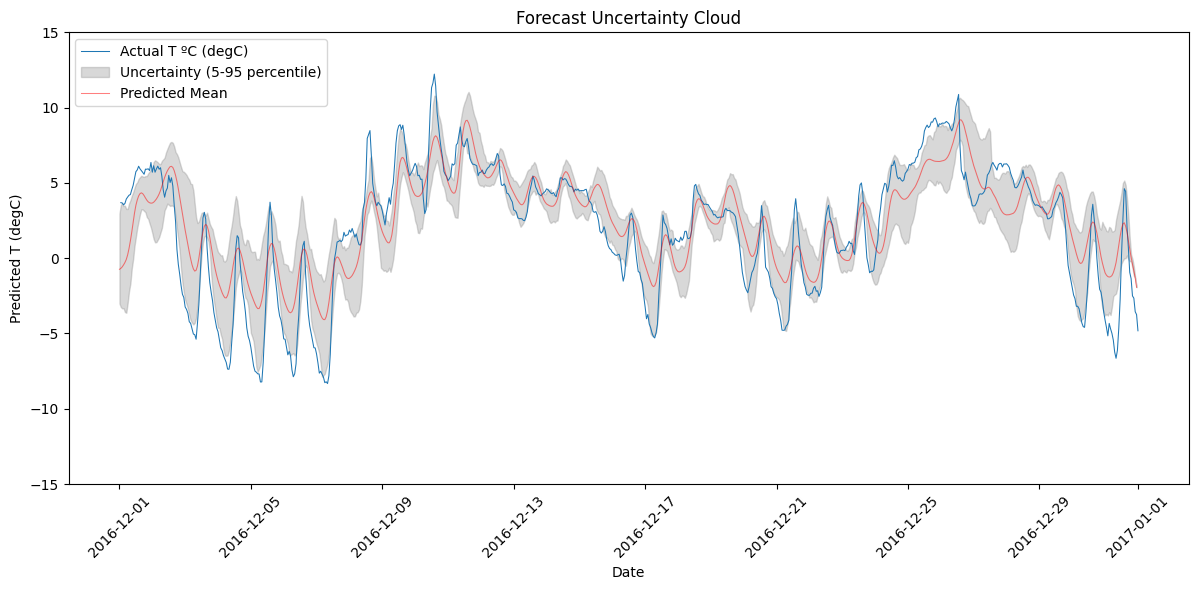

In [20]:
plt.figure(figsize=(12, 6))
# Plot the mean forecast
plt.plot(df[-24*31:].index, df['T (degC)'][-24*31:], linewidth=0.75, label='Actual T ºC (degC)') # Plot actual for the longest forecast period
# Plot uncertainty cloud using fill_between
plt.fill_between(summary_df.index, summary_df['lower'], summary_df['upper'], color='gray', alpha=0.3, label='Uncertainty (5-95 percentile)')
plt.plot(summary_df.index, summary_df['mean'], color='red', linewidth=0.75, alpha=0.5, label='Predicted Mean')
plt.xlabel("Date")
plt.ylabel("Predicted T (degC)")
plt.title("Forecast Uncertainty Cloud")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-15, 15)
plt.show()

In [19]:
# Define the current forecast period. In your code, actuals are taken as:
actual_period = df[-24*31:]  # adjust accordingly

# Align summary_df and actual values by index
common_index = summary_df.index.intersection(actual_period.index)
y_true = actual_period.loc[common_index, 'T (degC)']
y_pred = summary_df.loc[common_index, 'mean']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 1.8608248103177782
MSE: 5.161296204905312
R²: 0.7177713867570545
